In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
import astropy.coordinates as coords

In [2]:
plt.rc('figure', dpi=120)

Notations:
- the star has abundances $[X_k/H]$
- the mass of the star is $M$
- the mass fraction in the convective zone is $\alpha$
- the Earth composition in parts per million in mass is $g_k$ for element $k$
- the mass of rocks added: $m$ (_not to be confused with $m_k$ which is the mass of element $k$ in arbitrary unit_)
- the star's composition in mass fraction $f_k$

$f_k$ is related to $[X_k/H]$ as
$$ f_k = \frac{10^{[X_k/H]}m_k}{\Sigma_i 10^{[X_k/H]}m_k}$$

Consider $[X_k/Fe]$ after rocks of mass $m$ with composition $f_k$ has been added, and mixed thoroughly in the photosphere and convective zone, affecting the mass of $\alpha M$.

$$[X_k/\mathrm{Fe}] = \log_{10} \left( \frac{(f_k \alpha M + g_k m)/m_k}{(f_\mathrm{Fe}\alpha M + g_\mathrm{Fe} m)/m_\mathrm{Fe}} \right) - \log_{10} \frac{n_{k,\odot}}{n_{\mathrm{Fe}, \odot}}$$

Take derivative with respect to $m$:

$$ \frac{d\ln Q_k}{dm} \equiv \ln 10 \frac{d [X_k/\mathrm{Fe}]}{d m} = \left(\frac{g_k}{f_k\alpha M + g_k m} - \frac{g_\mathrm{Fe}}{f_\mathrm{Fe}\alpha M + g_\mathrm{Fe} m} \right)$$

When $m=0$,

$$\frac{d\ln Q_k}{dm} = \left( \frac{g_k}{f_k} - \frac{g_\mathrm{Fe}}{f_\mathrm{Fe}} \right) \frac{1}{\alpha M}
$$

When $m/(\alpha M) \ll 1$,
$$ \frac{d\ln Q_k}{dm} \approx \left( \frac{g_k}{f_k} - \frac{g_\mathrm{Fe}}{f_\mathrm{Fe}} \right)
\left( 1-\left(\frac{g_k}{f_k} + \frac{g_\mathrm{Fe}}{f_\mathrm{Fe}}\right)\frac{m}{\alpha M}\right)\frac{1}{\alpha M} + \mathcal{O}((\frac{m}{\alpha M})^2)$$


SMOH: By choosing a small bin in spectral parameters ($T_\mathrm{eff}$, $\log g$, [Fe/H]), we have a handle on

- $\alpha$, which fortunately stays roughly constant after the first Gyr of a star's life,
- $M$,
- $f_\mathrm{Fe}$

But what about $f_k$? Since we will derive the spectral expectation (i.e., "mean" spectrum) for the given spectral parameters, this spectrum contains the information about the mean abundance $[X_k/\mathrm{Fe}]$ or equivalently $f_k$. A way would be to do measure abundances (+ dispersions?) from the mean spectra. Another is to make a strong assumption that the metal abundance pattern is e.g., sun-like (something we know).

In [3]:
ls -1 data/

asplund2009.csv
atomicmass.csv
mcdonough2003.csv


In [4]:
solar = pd.read_csv("data/asplund2009.csv", skipinitialspace=True, comment='#')
atomic = pd.read_csv("data/atomicmass.csv", skipinitialspace=True, comment='#')
earth = pd.read_csv("data/mcdonough2003.csv", skipinitialspace=True, comment='#')

In [5]:
solar.head()

,Z,element,photosphere,photosphere_error,CIchon_LPG09,CIchon_LPG09_error
0,1,H,12.00,NaN,8.22,0.04
1,2,He,10.93,0.01,1.29,NaN
2,3,Li,1.05,0.10,3.26,0.05
3,4,Be,1.38,0.09,1.30,0.03
4,5,B,2.70,0.20,2.79,0.04


In [6]:
earth.head()

,element,bulk
0,H,260.00
1,Li,1.10
2,Be,0.05
3,B,0.20
4,C,730.00


In [7]:
atomic.head()

,Z,element,Name,weight
0,1,H,Hydrogen,1.008
1,2,He,Helium,4.002
2,3,Li,Lithium,6.940
3,4,Be,Beryllium,9.012
4,5,B,Boron,10.810


In [8]:
tb = pd.merge(solar[['Z','element','photosphere']], earth, how='outer', on='element')
tb = pd.merge(tb, atomic[['element','Name','weight']], how='left', on='element')
tb.head()

,Z,element,photosphere,bulk,Name,weight
0,1,H,12.00,260.00,Hydrogen,1.008
1,2,He,10.93,NaN,Helium,4.002
2,3,Li,1.05,1.10,Lithium,6.940
3,4,Be,1.38,0.05,Beryllium,9.012
4,5,B,2.70,0.20,Boron,10.810


Some elements are missing in either solar photospheric or bulk earth composition.

In [9]:
tb.loc[tb.isnull()[['photosphere','bulk']].values.any(axis=1)]

,Z,element,photosphere,bulk,Name,weight
1,2,He,10.93,NaN,Helium,4.0020
9,10,Ne,7.93,NaN,Neon,20.1797
17,18,Ar,6.40,NaN,Argon,39.9480
32,33,As,NaN,1.700,Arsenic,74.9210
33,34,Se,NaN,2.700,Selenium,78.9710
34,35,Br,NaN,0.300,Bromine,79.9040
35,36,Kr,3.25,NaN,Krypton,83.7980
46,48,Cd,NaN,0.080,Cadmium,112.4140
49,51,Sb,NaN,0.050,Antimony,121.7600
50,52,Te,NaN,0.300,Tellurium,127.6000


In [10]:
tb.photosphere.min()

0.02

In [11]:
tb.bulk.sum()   # should be 1000000 because it's parts per million ...

1000790.7289999999

In [12]:
f_k = tb.weight*10**tb.photosphere/(tb.weight*10**tb.photosphere.fillna(-2)).sum()
g_k = tb.bulk / 1e6

Fe = np.where(tb.element == 'Fe')[0][0]

In [13]:
print('Asplund 2009 solar X={:.4f} Y={:.4f} Z={:.4f}'.format(
    f_k[0], f_k[1], f_k[2:].sum()))

Asplund 2009 solar X=0.7374 Y=0.2492 Z=0.0134


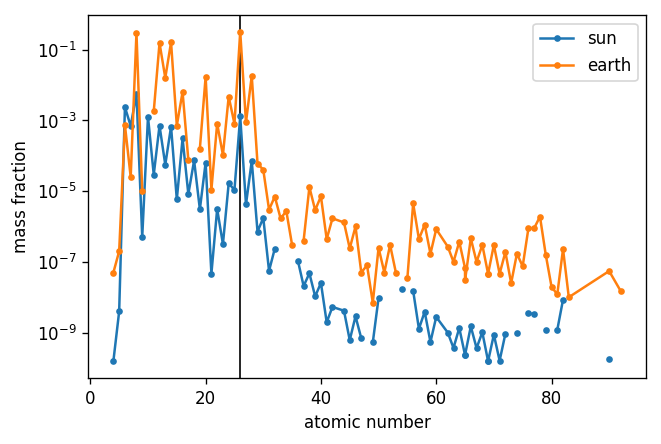

In [14]:
plt.plot(tb.Z[3:], f_k[3:], '.-', label='sun')
plt.plot(tb.Z[3:], g_k[3:], '.-', label='earth')
plt.yscale('log')
plt.axvline(tb.Z[Fe], c='k', lw=1, zorder=-10)
plt.ylabel('mass fraction')
plt.xlabel('atomic number')
plt.legend(loc='upper right');

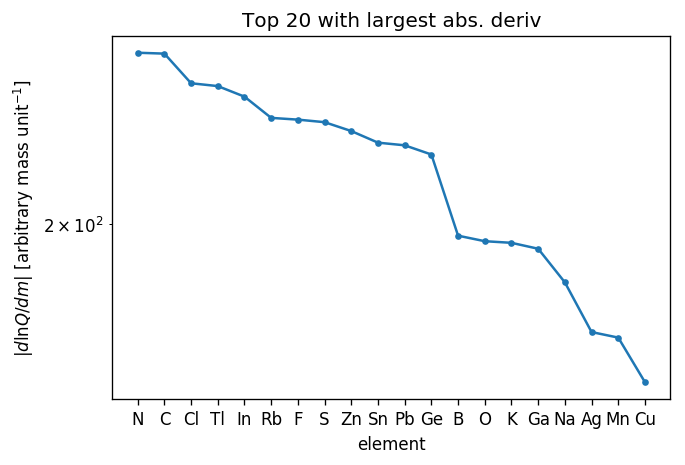

In [15]:
diff = g_k[3:]/f_k[3:]- g_k[25]/f_k[25]
absdiff = np.fabs(diff)
Z = tb.Z[3:].values
element = tb.element[3:]
N = 20
plt.plot(np.arange(N), absdiff.sort_values(ascending=False)[:N], '.-')
plt.xticks(np.arange(N), tb.element[absdiff.sort_values(ascending=False).index][:N]);
plt.ylabel('$|d \ln Q / d m|$ [arbitrary mass unit$^{-1}$]');
plt.xlabel('element')
plt.title('Top {:d} with largest abs. deriv'.format(N));
plt.yscale('log')

The most _informative_ element also depends on the spectral response, $d f_\lambda/d \ln Q_k$.

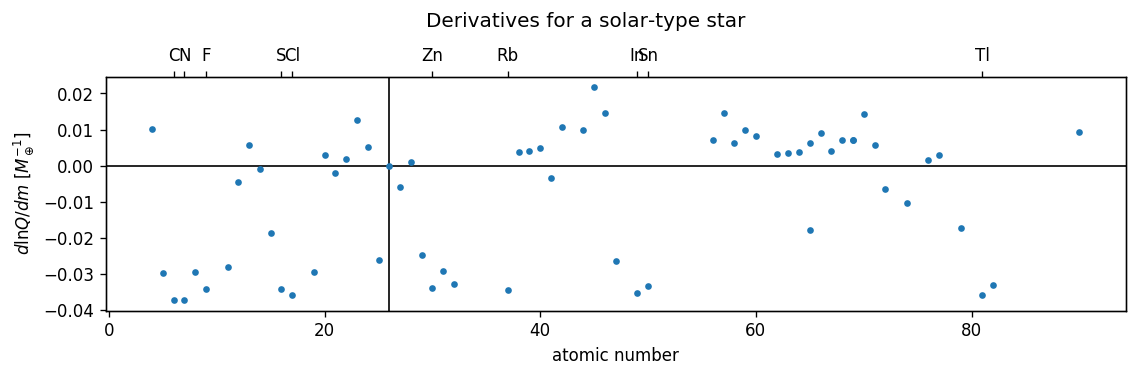

In [16]:
plt.figure(figsize=(10,3))
ax = plt.axes([0.1,0.15,0.85,0.65])
alpha = 0.02
M = (u.solMass).to(u.earthMass)
m = 0.

# term1 = g_k / (f_k * alpha * M + g_k * m)
# term2 = g_k[Fe] / (f_k[Fe] * alpha * M + g_k[Fe] * m)
deriv = g_k / (f_k * alpha * M + g_k * m) - g_k[Fe] / (f_k[Fe] * alpha * M + g_k[Fe] * m)
l, = plt.plot(tb.Z[3:], deriv[3:], '.')

plt.xlabel('atomic number')
plt.ylabel('$d \ln Q / d m$ [$M_\oplus^{-1}$]')
plt.axhline(0, c='k', lw=1, zorder=-10)
plt.axvline(tb.Z[Fe], c='k', lw=1, zorder=-15)

ax2 = plt.twiny()
ax2.set_xlim(ax.get_xlim())
plt.xticks(tb.Z[absdiff.sort_values(ascending=False).index[:10]],
           tb.element[absdiff.sort_values(ascending=False).index[:10]]);
plt.suptitle('Derivatives for a solar-type star');